# QEP Regression with Uncertain Inputs

## Introduction

In this notebook, we're going to demonstrate one way of dealing with uncertainty in our training data. Let's say that we're collecting training data that models the following function.

$$
\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2) 
\end{align}
$$

However, now assume that we're a bit uncertain about our features. In particular, we're going to assume that every `x_i` value is not a point but a distribution instead. E.g.

$$ x_i \sim \mathcal{Q}(\mu_i, \sigma_i). $$

## Using stochastic variational inference to deal with uncertain inputs

To deal with this uncertainty, we'll use variational inference (VI) in conjunction with stochastic optimization. At every optimization iteration, we'll draw a sample `x_i` from the input distribution. The objective function (ELBO) that we compute will be an unbiased estimate of the true ELBO, and so a stochastic optimizer like Adam should converge to the true ELBO (or at least a local minimum of it).

In [1]:
import math
import torch
import tqdm
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 20 regularly spaced points on [0,1].
We'll represent each of the training points $x_i$ by their mean $\mu_i$ and variance $\sigma_i$.

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x_mean = torch.linspace(0, 1, 20)
# We'll assume the variance shrinks the closer we get to 1
train_x_stdv = torch.linspace(0.03, 0.01, 20)

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x_mean * (2 * math.pi)) + torch.randn(train_x_mean.size()) * 0.2

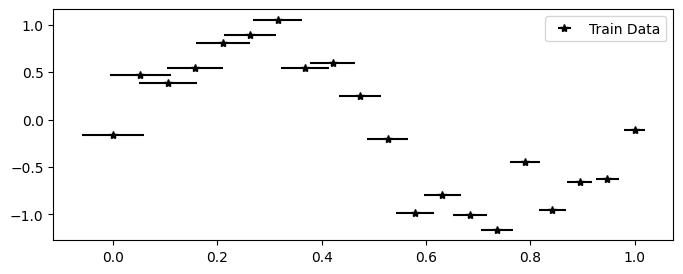

In [3]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(train_x_mean, train_y, xerr=(train_x_stdv * 2), fmt="k*", label="Train Data")
ax.legend()

## Setting up the model

Since we're performing VI to deal with the feature uncertainty, we'll be using a `~qpytorch.models.ApproximateQEP`. Similar to the [SVQEP example](./SVQEP_Regression_CUDA.ipynb), we'll use a `VariationalStrategy` and a `CholeskyVariationalDistribution` to define our posterior approximation.

In [5]:
from qpytorch.models import ApproximateQEP
from qpytorch.variational import CholeskyVariationalDistribution
from qpytorch.variational import VariationalStrategy
POWER = 1.0

class QEPModel(ApproximateQEP):
    def __init__(self, inducing_points):
        self.power = torch.tensor(POWER)
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0), power=self.power)
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(QEPModel, self).__init__(variational_strategy)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = qpytorch.kernels.ScaleKernel(qpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)


inducing_points = torch.randn(10, 1)
model = QEPModel(inducing_points=inducing_points)
likelihood = qpytorch.likelihoods.QExponentialLikelihood(power=model.power)

## Training the model with uncertain features

The training iteration should look pretty similar to the SVQEP example -- where we optimize the variational parameters and model hyperparameters. The key difference is that, at every iteration, we will draw samples from our features distribution (since we don't have point measurements of our features).

```python
# Inside the training iteration...
train_x_sample = qpytorch.distributions.QExponential(train_x_mean, train_x_stdv).rsample()
# Rest of training iteration...
```

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 400


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = qpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

iterator = tqdm.notebook.tqdm(range(training_iter))
for i in iterator:
    # First thing: draw a sample set of features from our distribution
    train_x_sample = qpytorch.distributions.QExponential(train_x_mean, train_x_stdv).rsample()
    
    # Now do the rest of the training loop
    optimizer.zero_grad()
    output = model(train_x_sample)
    loss = -mll(output, train_y)
    iterator.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

  0%|          | 0/400 [00:00<?, ?it/s]

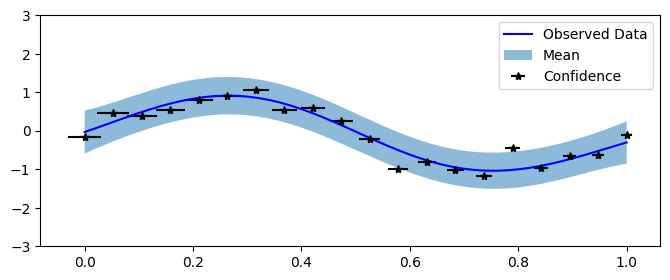

In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x_mean.numpy(), train_y.numpy(), xerr=train_x_stdv, fmt='k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

This is a toy example, but it can be useful in practice for more complex datasets where features are more likely to be missing.